<img src="./images/DLI_Header.png" style="width: 400px;">

# 5.0 Multi-Nodes Distributed Training for Computer Vision

In this notebook, we will learn how to train a simple Image Classifier in distributed mode.
We will first implement a vanilla pipeline parallel distribution. Then, we will use Microsoft's [DeepSpeed Library](https://www.deepspeed.ai/) for model distribution and optimization techniques.

## The goals

The goals of this notebook are to:
* Learn how to train a vanilla CNN
* Port the code to DeepSpeed library 
* Scale training using Data parallel distribution
* Optimize training with DeepSpeed autotuning and Zero Redundancy Optimizer


**[5.1 Convolutional Neural Network for Image Classification on CIFAR-10](#1.1-The-hardware-overview)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.1 The dataset](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.2 Convolutional Neural Network](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.3 Naive Model Distribution](#1.1.3-Check-The-Interconnect-Topology)<br>
**[5.2 Distributed Training with DeepSpeed](#1.1-The-hardware-overview)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1 Make the code run with DeepSpeed](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2 Scale-out training with Data Parallelism](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.3 Zero Redundancy Optimizer ](#1.1.3-Check-The-Interconnect-Topology)<br>

### Cancel Previous Running/Pending Jobs

Before moving on, check that no jobs are still running or waiting on the SLURM queue. Let's check the SLURM jobs queue by executing the following cell:


In [1]:
# Check the SLURM jobs queue 
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


If there are still jobs running or pending, execute the following cell to cancel all the user's jobs using the `scancel` command. 

In [2]:
# Cancel admin user jobs
!scancel -u $USER

# Check again the SLURM jobs queue (should be either empty, or the status TS column should be CG)
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


---
# 5.1 Convolutional Neural Network for Image Classification on CIFAR-10

## 5.1.1 The dataset


The [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60K images (50K for training and 10K for testing). Images are 32 by 32 pixels labelled with 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship and truck. 
In this lab, we will train a simple Convolutional Neural Network to classify CIFAR-10 images.

To download the dataset, we will use the [Torchvision](https://pytorch.org/vision/stable/index.html) package, a Pytorch library that contains popular datasets, model architectures, and common image transformations for Computer Vision.
<img src="images/CIFAR-10.jpg" width="350" />

Let's first import the relevant libraries by executing the next cell.

In [3]:
# import the relevant libraries
import torch
import torchvision
from IPython.display import display_html

def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

# define an image transform 
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Execute the next 2 cells to download the training and test CIFAR10 corpus.

In [4]:
# Download the CIFAR10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# Download the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified


Let's have a look at some examples:

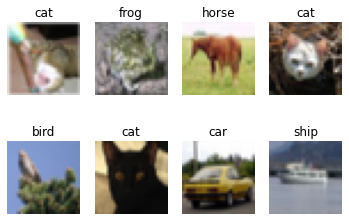

In [6]:
# Show some random training images
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels):
    for i in range(8): 
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.subplot(2,4,i+1)
        plt.imshow(np.transpose(npimg, (1, 2 , 0)));
        plt.axis('off');
        plt.title(classes[labels[i]])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images
imshow(images,labels)

## 5.1.2 Convolutional Neural Network

Let's define a neural network with 2 convolutional layers, first followed by a pooling layer then 3 fully connected layers. 

In [7]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net = CNN_Net()


In [8]:
# Copy the model to GPU 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_net.to(device)

CNN_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
# Let's have a look at the Convolutional Neural Network
from torchsummary import summary
summary(cnn_net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Let's define the optimizer and hyperparameters. We will use the Stochastic Gradient Descent (SGD) with momentum optimizer.

In [10]:
# Define the hyperparameters
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Tensorboard event recording directory 
writer = SummaryWriter('megatron/tensorboard/cifar10')

log_interval=100
batch_size=64
epochs=2

In [11]:
# Train the CNN
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()     
        
        # print the loss and accuracy metrics log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)

print('Training Done')
writer.add_graph(cnn_net, inputs)
writer.flush()
writer.close()

[epoch 0, iterations   100] loss: 2.305 accuracy: 8.781250 %
[epoch 0, iterations   200] loss: 2.304 accuracy: 9.312500 %
[epoch 0, iterations   300] loss: 2.304 accuracy: 9.635417 %
[epoch 0, iterations   400] loss: 2.303 accuracy: 10.128906 %
[epoch 0, iterations   500] loss: 2.301 accuracy: 10.334375 %
[epoch 0, iterations   600] loss: 2.302 accuracy: 10.294271 %
[epoch 0, iterations   700] loss: 2.301 accuracy: 10.310268 %
[epoch 0, iterations   782] loss: 2.300 accuracy: 10.570000 %
[epoch 1, iterations   100] loss: 2.298 accuracy: 14.640625 %
[epoch 1, iterations   200] loss: 2.296 accuracy: 15.351562 %
[epoch 1, iterations   300] loss: 2.294 accuracy: 15.505208 %
[epoch 1, iterations   400] loss: 2.290 accuracy: 15.699219 %
[epoch 1, iterations   500] loss: 2.284 accuracy: 16.240625 %
[epoch 1, iterations   600] loss: 2.272 accuracy: 16.888021 %
[epoch 1, iterations   700] loss: 2.247 accuracy: 17.296875 %
[epoch 1, iterations   782] loss: 2.202 accuracy: 17.760000 %
Training Do

### Monitor Training and Inspect the Model on Tensorboard 

We set the arguments for recording Tensorboard events in the previous CNN training. The training loss is available under the name `cifar10`. We can also visualize the model and navigate throughout its layers on the "Graphs" tab.

<img src="images/CNN.png" width="750"/>

Execute the next cell to create a link to Tensorboard for your browser. Then, click the link to see graphs of experiment metrics saved in the specified `Tensorboard` directory.

In [12]:
%%js
const href = window.location.hostname +'/tensorboard/';
let a = document.createElement('a');
let link = document.createTextNode('Open Tensorboard!');
a.appendChild(link);
a.href = "http://" + href;
a.style.color = "navy"
a.target = "_blank"
element.append(a);

<IPython.core.display.Javascript object>

### Evaluate The Trained Model

Let's evaluate the trained model on the CIFAR-10 test dataset. Execute the following cell to evaluate the accuracy on the test set. Accuracy detail per class will also be shown.

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %2f %%' %
      (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s : %2f %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of the network on the 10000 test images: 22.100000 %
Accuracy of plane : 35.714286 %
Accuracy of   car : 36.000000 %
Accuracy of  bird : 0.000000 %
Accuracy of   cat : 0.000000 %
Accuracy of  deer : 0.000000 %
Accuracy of   dog : 16.949153 %
Accuracy of  frog : 60.714286 %
Accuracy of horse : 17.187500 %
Accuracy of  ship : 60.344828 %
Accuracy of truck : 15.384615 %


# 5.1.3 Naive Model Distribution

Let's now implement a naive pipeline parallel distribution of the previous CNN model. To do so, we need to explicitly place each layer into the device and implement the forward pass, accordingly moving the corresponding outputs to match devices accordingly.




We will run the CNN model on two GPUs by placing: conv1 + pooling on GPU0 and conv2 + fc1 + fc2+ fc3 on GPU1. 
We will use torch *[TORCH.TENSOR.TO](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to)* to convert tensors to cuda and place them to the desired device. 

Have a look at modified class on the defined `Net_Parallel` class:

In [14]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class Net_Parallel(nn.Module):
    def __init__(self):
        super(Net_Parallel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5).to('cuda:0')               # Changed here
        self.pool = nn.MaxPool2d(2, 2).to('cuda:0')                # Changed here
        self.conv2 = nn.Conv2d(6, 16, 5).to('cuda:1')              # Changed here
        self.fc1 = nn.Linear(16 * 5 * 5, 120).to('cuda:1')         # Changed here
        self.fc2 = nn.Linear(120, 84).to('cuda:1')                 # Changed here
        self.fc3 = nn.Linear(84, 10).to('cuda:1')                  # Changed here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.to('cuda:0'))))          # Changed here
        x = self.pool(F.relu(self.conv2(x.to('cuda:1'))))          # Changed here
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net_pp = Net_Parallel()

Similar to the previous training execution, run the next 2 cells to define the optimizer/hyperparameters and then launch the training.

In [15]:
# Define the hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net_pp.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Tensorboard event recording directory 
writer_pp = SummaryWriter('megatron/tensorboard/cifar10_PP')                 

log_interval=100
batch_size=64
epochs=2

You can check the GPUs activity by running the next cell to open a terminal and the watch `nvidia-smi` command. 

In [16]:
%%html

<pre>
   Step 1: Open a terminal session by following the <a href="", data-commandlinker-command="terminal:create-new">Terminal link</a>
   Step 2: Check the GPUs: <font color="green">watch nvidia-smi</font>
</pre

Keep the terminal window opened and execute the next training.

In [17]:
# Train the CNN with pipeline parallel
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_net_pp(inputs.to('cuda:0'))                                # Changed here
        loss = criterion(outputs, labels.to('cuda:1'))                           # Changed here
        # Backward pass
        loss.backward()
        optimizer.step()
        torch.cuda.reset_max_memory_allocated(0)
        # print the loss and accuracy metrics log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.to('cuda:1')).sum().item()                 # Changed here
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer_pp.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer_pp.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)

print('Training Done')
writer_pp.add_graph(cnn_net_pp, inputs)
writer_pp.flush()
writer_pp.close()

/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


[epoch 0, iterations   100] loss: 2.304 accuracy: 9.781250 %
[epoch 0, iterations   200] loss: 2.302 accuracy: 10.085938 %
[epoch 0, iterations   300] loss: 2.301 accuracy: 10.218750 %
[epoch 0, iterations   400] loss: 2.298 accuracy: 10.304688 %
[epoch 0, iterations   500] loss: 2.294 accuracy: 10.668750 %
[epoch 0, iterations   600] loss: 2.288 accuracy: 11.161458 %
[epoch 0, iterations   700] loss: 2.276 accuracy: 11.794643 %
[epoch 0, iterations   782] loss: 2.264 accuracy: 12.312000 %
[epoch 1, iterations   100] loss: 2.237 accuracy: 18.890625 %
[epoch 1, iterations   200] loss: 2.199 accuracy: 19.140625 %
[epoch 1, iterations   300] loss: 2.142 accuracy: 20.072917 %
[epoch 1, iterations   400] loss: 2.111 accuracy: 21.113281 %
[epoch 1, iterations   500] loss: 2.075 accuracy: 22.025000 %
[epoch 1, iterations   600] loss: 2.032 accuracy: 22.640625 %
[epoch 1, iterations   700] loss: 2.000 accuracy: 23.388393 %
[epoch 1, iterations   782] loss: 1.968 accuracy: 23.890000 %
Training 

# 5.2 Distributed Training with DeepSpeed

The DeepSpeed library is a Deep Learning optimization library for distributed training on several different hardware sizes ranging from a single GPU to low-end clusters, going up to massive supercomputers.

<img src="https://www.deepspeed.ai/assets/images/3d-parallelism.png" width="650" />


- Distributed Training with Mixed Precision on Single-GPU/Multi-GPU/Multi-Node
- Pipeline Parallelism and an integration with Megatron-LM tensor parallel 
- Zero Redundancy Optimizer (ZeRO): Memory optimization techniques
- ZeRO-Offload: Offloading data and compute to the CPU
- Mixture of Experts (MoE)

## 5.2.1 Make the code run with DeepSpeed

The DeepSpeed engine can wrap neural networks defined as `torch.nn.module`. To write the previous Model with DeepSpeed, we will need to:

- Instantiate the DeepSpeed Model engine and optimizer: Use the DeepSpeed initializer as follows: 
`model_engine, optimizer= deepspeed.initialize(args=args, model=Your_Network, model_parameters=parameters, training_data=trainset)`
- The variable `args` should embed training arguments and the DeepSpeed arguments. We can use `deepspeed.add_config_arguments(parser)` to add the DeepSpeed arguments to our parser.
- Refer to the deepspeed `model_engine` instead of `Your_Network` in the rest of the code.
- For distributed training implementation with `torch.distributed.init_process_group(...)`, replace that with `deepspeed.init_distributed()`

Learn more on how to write DeepSpeed models with the [dedicated DeepSpeed documentation.](https://www.deepspeed.ai/getting-started/#writing-deepspeed-models) 

DeepSpeed arguments can be passed throughout a JSON configuration file. Let's have a look at our the DeepSpeed configuration file:

In [18]:
# Have a look at the DeepSpeed config
!cat code/moe/ds_config.json

{
  "train_batch_size": 16,
  "steps_per_print": 2000,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.001,
      "betas": [
        0.8,
        0.999
      ],
      "eps": 1e-8,
      "weight_decay": 3e-7
    }
  },
  "scheduler": {
    "type": "WarmupLR",
    "params": {
      "warmup_min_lr": 0,
      "warmup_max_lr": 0.001,
      "warmup_num_steps": 1000
    }
  },
  "gradient_clipping": 1.0,
  "prescale_gradients": false,
  "fp16": {
      "enabled": true,
      "fp16_master_weights_and_grads": false,
      "loss_scale": 0,
      "loss_scale_window": 500,
      "hysteresis": 2,
      "min_loss_scale": 1,
      "initial_scale_power": 15
  },
  "wall_clock_breakdown": false,
  "zero_optimization": {
      "stage": 0,
      "allgather_partitions": true,
      "reduce_scatter": true,
      "allgather_bucket_size": 50000000,
      "reduce_bucket_size": 50000000,
      "overlap_comm": true,
      "contiguous_gradients": true,
      "cpu_offload": false
  } 

}

In [19]:
# import the relevant library
import deepspeed

# define the argument class, the training arguments, and DeepSpeed
class Args:
    log_interval=100 
    batch_size=64
    epochs=2
    deepspeed = True
    deepspeed_config = "code/moe/ds_config.json"
    local_rank= 0

args=Args()

In [20]:
# define the CNN network
cnn_net_ds = CNN_Net()

# Define the hyperparameters
parameters = filter(lambda p: p.requires_grad, cnn_net_ds.parameters())

# Wrap the CNN network with DeepSpeed
model_engine, optimizer, _, _ = deepspeed.initialize(args=args, model=cnn_net_ds, model_parameters=parameters, training_data=trainset)

# enable mixed precision
fp16 = model_engine.fp16_enabled()

device = model_engine.local_rank
criterion = nn.CrossEntropyLoss()

# Tensorboard event recording directory 
writer_ds = SummaryWriter('megatron/tensorboard/cifar10_DS')                 

[2023-06-27 15:01:01,928] [INFO] [logging.py:69:log_dist] [Rank -1] DeepSpeed info: version=0.6.5, git-hash=unknown, git-branch=unknown
[2023-06-27 15:01:01,929] [INFO] [distributed.py:36:init_distributed] Not using the DeepSpeed or torch.distributed launchers, attempting to detect MPI environment...
[2023-06-27 15:01:02,146] [INFO] [distributed.py:85:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.18.0.5, master_port=29500
[2023-06-27 15:01:02,149] [INFO] [distributed.py:48:init_distributed] Initializing torch distributed with backend: nccl
[2023-06-27 15:01:02,410] [INFO] [engine.py:278:__init__] DeepSpeed Flops Profiler Enabled: False
Using /home/admin/.cache/torch_extensions/py38_cu115 as PyTorch extensions root...
Creating extension directory /home/admin/.cache/torch_extensions/py38_cu115/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/admin/.cache/torch_extensions/py38_cu115/fused_adam/build.n

In [21]:
# Train the CNN with DeepSpeed
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        if fp16:
            inputs = inputs.half()        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_engine(inputs)             # Changed net_cnn to model_engine
        loss = criterion(outputs, labels)
        
        # Backward pass
        model_engine.backward(loss)                # Changed net_cnn to model_engine
        model_engine.step()                        # Changed net_cnn to model_engine
        
        # print the loss and accuracy metrics log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer_ds.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer_ds.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
            
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
    
print('Training Done')
writer_ds.add_graph(model_engine, inputs)
writer_ds.flush()
writer_ds.close()

[epoch 0, iterations   100] loss: 2.124 accuracy: 20.328125 %
[epoch 0, iterations   200] loss: 1.842 accuracy: 26.171875 %
[epoch 0, iterations   300] loss: 1.702 accuracy: 29.770833 %
[epoch 0, iterations   400] loss: 1.627 accuracy: 32.460938 %
[epoch 0, iterations   500] loss: 1.583 accuracy: 34.406250 %
[2023-06-27 15:01:35,387] [INFO] [fused_optimizer.py:392:_update_scale] No Grad overflow for 500 iterations
[2023-06-27 15:01:35,388] [INFO] [fused_optimizer.py:394:_update_scale] Increasing dynamic loss scale from 32768 to 65536
[2023-06-27 15:01:35,394] [INFO] [fused_optimizer.py:382:_update_scale] 
Grad overflow on iteration 501
[2023-06-27 15:01:35,394] [INFO] [fused_optimizer.py:383:_update_scale] Reducing dynamic loss scale from 65536 to 32768.0
[2023-06-27 15:01:35,395] [INFO] [logging.py:69:log_dist] [Rank 0] Overflow detected. Skipping step. Attempted loss scale: 65536, reducing to 32768.0
[epoch 0, iterations   600] loss: 1.555 accuracy: 35.929688 %
[epoch 0, iterations  

The previous steps are aggregated into the python script [cifar10_deepspeed.py](./code/moe/cifar10_deepspeed.py). 

## 5.2.2 Scale-out training with Data Parallelism 

Let's now scale our previous training using distributed training techniques. To run the previous code on 4 GPUs using Data Parallel Distribution, instead of using torch.distributed.launch command, we can use deepspeed implementation.

`python -m torch.distributed.launch --nproc_per_node=4 my_code.py <args>`

With DeepSpeed, simply replace torch.distributed.launch with deepspeed and add a new argument --deepspeed ds_config.json

`deepspeed --num_gpus=4 my_code.py  <args> --deepspeed ds_config.json`

Execute the next cell to run the previous cifar10_deepspeed.py training code on 4 GPUs with DeepSpeed:

In [22]:
# Kill zombie processes
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# run the training on 4 GPUs with Data parallel
!deepspeed --num_gpus=4 /dli/code/moe/cifar10_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config.json \
    --profile-execution=True \
    --profile-name='zero0'

[2023-06-27 15:03:06,596] [WARNING] [runner.py:159:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2023-06-27 15:03:06,779] [INFO] [runner.py:457:main] cmd = /opt/conda/bin/python3.8 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 /dli/code/moe/cifar10_deepspeed.py --deepspeed --deepspeed_config /dli/code/moe/ds_config.json --profile-execution=True --profile-name=zero0
[2023-06-27 15:03:07,726] [INFO] [launch.py:96:main] 0 NCCL_P2P_DISABLE=1
[2023-06-27 15:03:07,726] [INFO] [launch.py:96:main] 0 NCCL_VERSION=2.11.4
[2023-06-27 15:03:07,726] [INFO] [launch.py:103:main] WORLD INFO DICT: {'localhost': [0, 1, 2, 3]}
[2023-06-27 15:03:07,727] [INFO] [launch.py:109:main] nnodes=1, num_local_procs=4, node_rank=0
[2023-06-27 15:03:07,727] [INFO] [launch.py:122:main] global_rank_mapping=defaultdict(<class 'list'>, {'localhost': [0, 1, 2, 3]})
[2023-06-27 15:03:07,727] [I

To execute the same run on a SLURM based cluster, simply write the SBATCH script allocating the desired resources and invoke the same DeepSpeed command. 

Run the next cell to create the SBATCH script allocating 2 nodes to run the previous training with DeepSpeed.

In [ ]:
%%writefile /dli/code/run_cifar10_deepspeed_2Nodes.sh
#!/bin/bash
#SBATCH --job-name=dli_ds
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=1       
#SBATCH --cpus-per-task=32 ### Number of threads per task (OMP threads)
#SBATCH -o /dli/megatron/logs/%j.out
#SBATCH -e /dli/megatron/logs/%j.err

# Number of nodes
NUM_NODES=2
# Number of GPUs per node
NUM_GPUS=2


deepspeed --num_nodes=${NUM_NODES} --hostfile /dli/code/moe/hostfile --num_gpus=${NUM_GPUS} /dli/code/moe/cifar10_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config.json \
    --profile-execution=True \
    --profile-name='zero0_sbatch'

Now, let's submit the previous sbatch script [run_cifar10_deepspeed_2Nodes.sh](./code/run_cifar10_deepspeed_2Nodes.sh) and check the SLURM queue using the `squeue` command.

In [ ]:
# Submit the 2 nodes jobs
!sbatch /dli/code/run_cifar10_deepspeed_2Nodes.sh

# Check the SLURM queue
!squeue

In [ ]:
# Check GPU utilization on the master node
!sleep 10
!nvidia-smi

## 5.2.3 Zero Redundancy Optimizer 

[ZeRO](https://www.deepspeed.ai/tutorials/zero/) reduces the memory consumption of each GPU by distributing the model's training states (weights, gradients, and optimizer states) across the available devices. ZeRO is implemented as 3 accumulative stages:

- **ZeRO-1:** The optimizer states are partitioned across the processes, so that each process updates only its partition. For instance, the Adam optimizer will store 32-bit weights, and the first, and second moment estimates.
- **ZeRO-2:** In addition to Zero 1, the reduced 32-bit gradients for updating the model weights are also partitioned such that each process retains only the gradients corresponding to its portion of the optimizer states.
- **ZeRO-3:** In addition to Zero 2, the 16-bit model parameters are partitioned across the processes. ZeRO-3 will automatically collect and partition them during the forward and backward passes. ZeRO-3 also includes the [ZeRO-Infinity](https://arxiv.org/pdf/2104.07857.pdf) engine that offloads to both CPU and NVMe memory for memory savings.

```
{
 "zero_optimization": {
    "stage": [0|1|2|3],
    "allgather_partitions": [true|false],
    "allgather_bucket_size": 5e8,
    "overlap_comm": false,
    "reduce_scatter": [true|false],
    "reduce_bucket_size": 5e8,
    "contiguous_gradients" : [true|false],
    "offload_param": {
      ...
    },
    "offload_optimizer": {
      ...
    },
    "stage3_max_live_parameters" : 1e9,
    "stage3_max_reuse_distance" : 1e9,
    "stage3_prefetch_bucket_size" : 5e8,
    "stage3_param_persistence_threshold" : 1e6,
    "sub_group_size" : 1e12,
    "elastic_checkpoint" : [true|false],
    "stage3_gather_16bit_weights_on_model_save": [true|false],
    "ignore_unused_parameters": [true|false]
    "round_robin_gradients": [true|false]
    }
  }

```


<video controls src="https://www.microsoft.com/en-us/research/uploads/prod/2020/02/Turing-Animation.mp4?_=1" width="560" />

In order to illustrate the advantages of ZeRO optimizer in memory saving, let's scale our CNN model to a larger neural network. We  replaced the tiny CNN network with the Resnet152 model with 11 million parameters in the [large_model_deepspeed.py](./code/moe/large_model_deepspeed.py).


The following figure shows the CPU usage via [htop](https://htop.dev/) command and the GPU 0 memory profiled using Pytorch Profiler (available on the Tensorboard) for the *resnet152* training step. We can see a comparison between no ZeRO and ZeRO stage 3 + Offload. The memory peak required per GPU without ZeRO optimizer is about 1.5GB, while offloading the parameters to the CPU with ZeRO-3 uses only 845MB. On the other hand, the time per step increased significantly from 500ms to 7000ms!

ZeRO infinity allows sacling to larger models when the number of GPUs are limited, but this comes with an additional training time corresponding to data movement.
<img src="images/zero_memory.png" width="1250" />


Let's run the Zero stage 3 optimizer and enable CPU offload of the parameters. We have prepared the configuration file. Notice that we have increased the training batch size per GPU to 512. 

In [ ]:
# Show DeepSpeed config file for Zero stage 3 Offload
!cat /dli/code/moe/ds_config_stage_3.json 

First, let's download the resnet152 model. More information about it can be found [here](https://pytorch.org/hub/pytorch_vision_resnet/)

In [ ]:
import torch
net = torch.hub.load("pytorch/vision:v0.10.0", "resnet152", force_reload=True, pretrained=True)

Execute the next cell to run the *resnet152* model training on the CIFAR-10 dataset. Notice that in these experiments, our focus is memory consumption as opposed to model accuracy.

In [ ]:
!deepspeed --num_gpus=4 /dli/code/moe/large_model_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config_stage_3.json \
    --profile-execution=True \
    --profile-name='zero_resnet152_stage3'


Execute the next cell to create a link to Tensorboard in your browser.

In [ ]:
%%js
const href = window.location.hostname +'/tensorboard/';
let a = document.createElement('a');
let link = document.createTextNode('Open Tensorboard!');
a.appendChild(link);
a.href = "http://" + href;
a.style.color = "navy"
a.target = "_blank"
element.append(a);

### Exercise: ZeRO Stage 1

Compare ZeRO Stage 1 execution time and GPU/CPU memory to no ZeRO and ZeRO Stage 3 + Offload. We have already prepared the DeepSpeed configuration file. Let's have a look:

In [ ]:
# Show DeepSpeed config file for Zero stage 1 
!cat /dli/code/moe/ds_config_stage_1.json 

Execute the next cell to run the *resnet152* model training on the CIFAR-10 dataset with ZeRO Stage1. Replace the `FIXME` with the corresponding arguments. If you get stuck, you can look at the [solution](solutions/ex5.2.4.ipynb).

In [ ]:
!deepspeed --num_gpus=4 /dli/code/moe/large_model_deepspeed.py \
    --deepspeed \
    --deepspeed_config #FIXEME \
    --profile-execution=True \
    --profile-name=#FIXEME 

Compared to the run without ZeRO, Stage 1 allows to reduce the GPU memory usage from about 1.5GB to 1GB as it partitions the optimizer states across 4 GPUs meaning that each GPU is responsible for keeping in memory a part of the optimizer states and communicate them when necessary to others. In this case, no significant extra time is observed to run the step with ZeRO Stage 1.

## Optional: 5.2.4  Autotuning

When designing training experiments, it is hard to know what are the best configurations (such as micro-batch size) that fully utilize the hardware and achieve a high throughput number. Usually, configuration exploration is performed manually. This tuning process can be painful, time-consuming and the configurations are hardware-dependent. The DeepSpeed Autotuner automatically discovers the optimal DeepSpeed configuration parameters that optimizes for training speed.
To launch the autotuning, add `--autotuning run` command to the training script and enable it on the configuration file as follows: 

```
{
  "train_micro_batch_size_per_gpu": "auto",

  "autotuning": {
    "enabled": true,
    "arg_mappings": {
      "train_micro_batch_size_per_gpu": "--batch_size"    }
  }
}
```
The arg_mappings dictionary autotuning section of the DeepSpeed configuration file provides the naming mappings between the parameters in DeepSpeed configuration and the training script arguments. It is also possible restrict the search space to a list of values by replacing "auto" with a vector of possible values to be evaluated. 

To learn more about the Autotuning feature, check the [DeepSpeed documentation](https://www.deepspeed.ai/tutorials/autotuning/)

---
<h2 style="color:green;">Congratulations!</h2>

Before moving on, we need to make sure no jobs are still running or waiting in the queue. 

In [ ]:
# Check the SLURM jobs queue 
!squeue

If there are still jobs running or pending, execute the following cell to cancel all the admin user's jobs using the `scancel` command.

In [ ]:
# Cancel admin user jobs
!scancel -u $USER

# Check again the SLURM jobs queue (should be either empty, or the status TS column should be CG)
!squeue

Next, we will see Mixture of Expert (MOE)configurations. Move on to [06_MOE_alternative_models.ipynb](06_MOE_alternative_models.ipynb).